In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import scipy.io as sio
from keras.layers import Conv1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks  import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#dataPath = '../data/butter_feature_tensor_with_labels.mat'
#dataPath = '../data/csp_features_full_with_full_labels.csv'
dataPath = '../data/iir_feat_tensor_full_with_full_labels.mat'
savePath = '../Results/CNN_1D_IIR/'

experiment = 'MultiClass_iir_NC'

filename = savePath+'CNN_1D_results_'+experiment+'.mat'
plot_title = 'Categorical Emotion Classification for IIR Features (NC)'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 30
momentum =0.8

matContent = sio.loadmat(dataPath)
features = matContent['nc_feat']
labels = np.squeeze(matContent['nc_multi_labels'])
labels[labels < 0] = 0
print(labels)
labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
#labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

[1 1 1 ... 6 6 6]


In [3]:
labels_categorical

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [4]:
class_num

6

In [5]:
features.shape

(6599, 640, 14)

In [6]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [7]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv1D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(X.shape[1], X.shape[2]), trainable=True))
  model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv1D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv1D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam(learning_rate=learn_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [8]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=0)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.00001, 0.0001, 0.001, 0.01]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu', 'tanh']
dropout_rate = [0.3, 0.4, 0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
feat_shape = features.shape
features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
scaler = StandardScaler()
scaler.fit(features)
scaleFeatures = scaler.transform(features)
scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 640, 14))

print('Performing Gridsearch')
X = scaleFeatures
Y = labels_categorical
grid_result = grid.fit(X,Y)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
tf.keras.backend.clear_session()
estimator = create_model(init_mode=best_params.get('init_mode'), 
                         learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), 
                         #momentum=best_params.get('momentum'), 
                         activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

Performing Gridsearch
Best parameters: {'activation': 'relu', 'dropout_rate': 0.3, 'init_mode': 'he_uniform', 'learn_rate': 0.001, 'optimizer': 'Adam'}


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 640, 16)           688       
_________________________________________________________________
average_pooling1d (AveragePo (None, 320, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 32)           1568      
_________________________________________________________________
average_pooling1d_1 (Average (None, 160, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 160, 32)           3104      
_________________________________________________________________
average_pooling1d_2 (Average (None, 80, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0

Epoch 5/30
168/168 - 1s - loss: 0.1038 - accuracy: 0.9645 - val_loss: 4.7152 - val_accuracy: 0.2525
Epoch 6/30
168/168 - 1s - loss: 0.1000 - accuracy: 0.9643 - val_loss: 4.4816 - val_accuracy: 0.3081
Epoch 7/30
168/168 - 1s - loss: 0.0822 - accuracy: 0.9716 - val_loss: 4.4868 - val_accuracy: 0.2761
Epoch 8/30
168/168 - 1s - loss: 0.0838 - accuracy: 0.9708 - val_loss: 5.0261 - val_accuracy: 0.2559
Epoch 9/30
168/168 - 1s - loss: 0.0896 - accuracy: 0.9678 - val_loss: 6.4444 - val_accuracy: 0.2391
Epoch 10/30
168/168 - 1s - loss: 0.0786 - accuracy: 0.9744 - val_loss: 5.0900 - val_accuracy: 0.2576
Epoch 11/30
168/168 - 1s - loss: 0.0788 - accuracy: 0.9755 - val_loss: 5.5894 - val_accuracy: 0.2811
Epoch 12/30
168/168 - 1s - loss: 0.0816 - accuracy: 0.9704 - val_loss: 5.5345 - val_accuracy: 0.2306
Epoch 13/30
168/168 - 1s - loss: 0.0951 - accuracy: 0.9680 - val_loss: 4.0721 - val_accuracy: 0.2761
Epoch 14/30
168/168 - 1s - loss: 0.0804 - accuracy: 0.9721 - val_loss: 5.0406 - val_accuracy: 0.

Epoch 1/30
168/168 - 1s - loss: 0.1248 - accuracy: 0.9624 - val_loss: 7.1926 - val_accuracy: 0.2896
Epoch 2/30
168/168 - 1s - loss: 0.1206 - accuracy: 0.9607 - val_loss: 6.8208 - val_accuracy: 0.2744
Epoch 3/30
168/168 - 1s - loss: 0.0825 - accuracy: 0.9734 - val_loss: 7.1543 - val_accuracy: 0.2811
Epoch 4/30
168/168 - 1s - loss: 0.0923 - accuracy: 0.9688 - val_loss: 5.6554 - val_accuracy: 0.2660
Epoch 5/30
168/168 - 1s - loss: 0.0943 - accuracy: 0.9688 - val_loss: 5.4545 - val_accuracy: 0.2963
Epoch 6/30
168/168 - 1s - loss: 0.0965 - accuracy: 0.9706 - val_loss: 7.0748 - val_accuracy: 0.2879
Epoch 7/30
168/168 - 1s - loss: 0.0791 - accuracy: 0.9704 - val_loss: 8.7092 - val_accuracy: 0.2643
Epoch 8/30
168/168 - 1s - loss: 0.0771 - accuracy: 0.9742 - val_loss: 8.3241 - val_accuracy: 0.2458
Epoch 9/30
168/168 - 1s - loss: 0.0652 - accuracy: 0.9764 - val_loss: 8.6881 - val_accuracy: 0.2593
Epoch 10/30
168/168 - 1s - loss: 0.0526 - accuracy: 0.9822 - val_loss: 7.7754 - val_accuracy: 0.2896

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 640, 16)           688       
_________________________________________________________________
average_pooling1d (AveragePo (None, 320, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 32)           1568      
_________________________________________________________________
average_pooling1d_1 (Average (None, 160, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 160, 32)           3104      
_________________________________________________________________
average_pooling1d_2 (Average (None, 80, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0

Epoch 13/30
168/168 - 1s - loss: 0.0562 - accuracy: 0.9835 - val_loss: 7.1082 - val_accuracy: 0.2980
Epoch 14/30
168/168 - 1s - loss: 0.0519 - accuracy: 0.9841 - val_loss: 7.7543 - val_accuracy: 0.2997
Epoch 15/30
168/168 - 1s - loss: 0.0516 - accuracy: 0.9820 - val_loss: 7.3388 - val_accuracy: 0.2929
Epoch 16/30
168/168 - 1s - loss: 0.0515 - accuracy: 0.9824 - val_loss: 6.9816 - val_accuracy: 0.2795
Epoch 17/30
168/168 - 1s - loss: 0.0691 - accuracy: 0.9802 - val_loss: 8.4105 - val_accuracy: 0.2677
Epoch 18/30
168/168 - 1s - loss: 0.0609 - accuracy: 0.9813 - val_loss: 10.4901 - val_accuracy: 0.2357
Epoch 19/30
168/168 - 1s - loss: 0.0509 - accuracy: 0.9833 - val_loss: 8.8169 - val_accuracy: 0.2929
Epoch 20/30
168/168 - 1s - loss: 0.0576 - accuracy: 0.9811 - val_loss: 5.9054 - val_accuracy: 0.2458
Epoch 21/30
168/168 - 1s - loss: 0.0521 - accuracy: 0.9819 - val_loss: 8.5592 - val_accuracy: 0.2795
Epoch 22/30
168/168 - 1s - loss: 0.0552 - accuracy: 0.9843 - val_loss: 6.0284 - val_accura

Epoch 1/30
168/168 - 1s - loss: 0.0662 - accuracy: 0.9804 - val_loss: 8.0498 - val_accuracy: 0.2912
Epoch 2/30
168/168 - 1s - loss: 0.0565 - accuracy: 0.9815 - val_loss: 7.2472 - val_accuracy: 0.2593
Epoch 3/30
168/168 - 1s - loss: 0.0580 - accuracy: 0.9802 - val_loss: 6.5124 - val_accuracy: 0.2946
Epoch 4/30
168/168 - 1s - loss: 0.0504 - accuracy: 0.9837 - val_loss: 6.2831 - val_accuracy: 0.2727
Epoch 5/30
168/168 - 1s - loss: 0.0595 - accuracy: 0.9807 - val_loss: 8.1592 - val_accuracy: 0.2912
Epoch 6/30
168/168 - 1s - loss: 0.0528 - accuracy: 0.9850 - val_loss: 8.4335 - val_accuracy: 0.2677
Epoch 7/30
168/168 - 1s - loss: 0.0590 - accuracy: 0.9813 - val_loss: 7.9031 - val_accuracy: 0.3030
Epoch 8/30
168/168 - 1s - loss: 0.0544 - accuracy: 0.9832 - val_loss: 8.5395 - val_accuracy: 0.2525
Epoch 9/30
168/168 - 1s - loss: 0.0453 - accuracy: 0.9835 - val_loss: 8.0861 - val_accuracy: 0.2862
Epoch 10/30
168/168 - 1s - loss: 0.0411 - accuracy: 0.9860 - val_loss: 8.0364 - val_accuracy: 0.3131

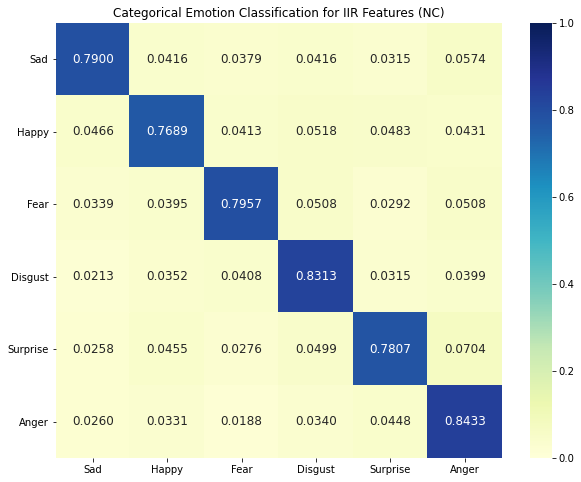

Mean and std of F1 MACRO is 0.7995 +- 0.1918
Mean and std of F1 WEIGHTED is 0.7996 +- 0.1917
Mean and std of accuracy is 0.8015 +- 0.1870


In [9]:
conf_mat = np.zeros((6,6))
f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=101, shuffle=True)

features = np.reshape(features, (features.shape[0],640,14)) #reshaped to (None, 3, 14) for spectral

for train, test in kfold.split(features, labels):
    trainingFeatures = features[train,:,:]
    testFeatures = features[test,:,:]
    train_shape = trainingFeatures.shape
    test_shape = testFeatures.shape
    
    # Standerdize 
    scaler = StandardScaler()
    trainingFeatures = np.reshape(trainingFeatures, [train_shape[0], train_shape[1]*train_shape[2]])
    testFeatures = np.reshape(testFeatures, [test_shape[0], test_shape[1]*test_shape[2]])
    scaler.fit(trainingFeatures)
    trainingFeatures = scaler.transform(trainingFeatures)
    trainingFeatures = np.reshape(trainingFeatures, [train_shape[0],train_shape[1],train_shape[2]])
    testFeatures = scaler.transform(testFeatures)
    testFeatures = np.reshape(testFeatures,[test_shape[0], test_shape[1], test_shape[2]])
    tf.keras.backend.clear_session()
    estimator.summary()
    estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                epochs=epochs, verbose=2, validation_split=0.1)
    
    predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
    predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
    cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[1, 2, 3, 4, 5, 0])
    conf_mat = conf_mat+cm

    precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
    recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
    f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
    f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
    accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
    print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
    print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
    print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
    f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['NC', 'PD'], rotation = 0)
#ax.set_yticklabels(['LV', 'HV'], rotation = 0)
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
#ax.set_xticklabels(['LV', 'HV'], rotation = 0)
#ax.set_xticklabels(['NC', 'PD'], rotation = 0)

ax.set_title(plot_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat,
                      'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs})